In [1]:
import jax
jax.config.update("jax_enable_x64", True)


import matplotlib.pyplot as plt
from matplotlib import colormaps, colors

%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 120

inferno = colormaps["inferno"]
seismic = colormaps["seismic"]

inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)

In [2]:
from amigo.files import get_files
from amigo.files import summarise_files

# Bind file path, type and exposure type
file_fn = lambda **kwargs: get_files(
    [
        "/Users/louis/Data/JWST/amigo_data/CAL04481/calslope/",
    ],
    "calslope",
    EXP_TYPE="NIS_AMI",
    IS_PSF=[True],  # Calibrators
    EXPOSURE=[str(i + 1) for i in range(1)],  # Which sub-pixel position
    **kwargs,
)

files = [] + file_fn(FILTER="F380M") + file_fn(FILTER="F430M") + file_fn(FILTER="F480M")

print(f"\n{len(files)}")
summarise_files(
    files,
    ["TARGPROP", "FILTER", "NINTS", "NGROUPS", "OBSERVTN", "NCHUNKS", "EXPOSURE"],
)

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-063 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-065
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf



3
  TARGPROP: HD-41094
  FILTER: F480M, F430M, F380M
  NINTS: 760, 905, 1060
  NGROUPS: 11, 20, 30
  OBSERVTN: 001
  NCHUNKS: 1
  EXPOSURE: 1


In [3]:
import jax.numpy as np

for file in files:
    file["SCI"].data[:, :, -1:] = np.nan
    file["SCI_VAR"].data[:, :, -1:] = np.nan
    file["ZPOINT"].data[:, -1:] = np.nan
    file["ZPOINT_VAR"].data[:, -1:] = np.nan

    file["SCI"].data[:, 41:43, 1] = np.nan

In [4]:
import jax.numpy as np
from zodiax.experimental import deserialise
from amigo.files import repopulate
from amigo.core_models import AmigoModel
from amigo.optical_models import AMIOptics
from amigo.detector_models import LinearDetectorModel
from amigo.read_models import ReadModel
from amigo.ramp_models import SimpleRamp, PolyNonLin
from amigo.vis_models import SplineVis
from amigo.files import get_exposures, initialise_params
from amigo.model_fits import SplineVisFit

optics = AMIOptics()
vis_model = SplineVis(optics, x_osamp=3, y_osamp=2)
detector = LinearDetectorModel()
ramp_model = PolyNonLin(orders=[2], norm=1e-3)
read_model = ReadModel()

# Prep the model
fit = SplineVisFit(joint_fit=False)
exposures = get_exposures(files, fit)
params = initialise_params(exposures, optics, vis_model=vis_model)

# Add the binary parameters
model = AmigoModel(
    files,
    params,
    optics=optics,
    detector=detector,
    ramp=ramp_model,
    read=read_model,
    visibilities=vis_model,
)

In [5]:
import jax
import equinox as eqx
import jax.numpy as np
import jax.random as jr

# This is normal PolyConv
kernel_size = 12
basis = np.ones((4, 320, 320))
conv = eqx.nn.Conv2d(
    len(basis), 1, kernel_size, stride=4, padding=(4, 4), key=jr.PRNGKey(0)
)
print(conv(basis).shape)

(1, 80, 80)


23531.4259664121
25000.000000000025


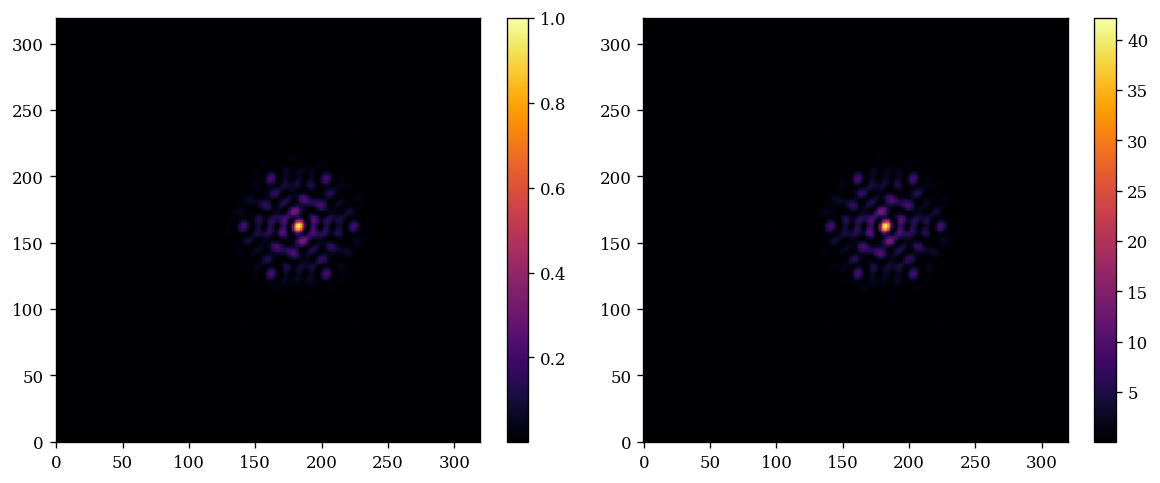

In [6]:
max_flux = 25e3
steps = 10

psf = fit.model_psf(model, exposures[0]).data
psf_norm = psf / psf.max()

photons = psf_norm / steps

charge = np.zeros_like(photons)
for i in range(steps):
    charge += photons

true_charge = max_flux * charge * psf.max()

print(true_charge.sum())
print(true_charge.sum() / psf.sum())

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(charge)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(true_charge)
plt.colorbar()

plt.tight_layout()
plt.show()

In [7]:
from amigo.ramp_models import build_image_basis

im = np.ones((320, 320))
basis = np.vstack([build_image_basis(im), build_image_basis(im)])

# Minimal recurrent structure
kernel_size = 5  # Must be odd - determines field of regard
pad = kernel_size // 2
conv = eqx.nn.Conv2d(
    in_channels=len(basis),
    out_channels=1,
    kernel_size=kernel_size,
    padding=(pad, pad),
    key=jr.PRNGKey(0),
)
print(conv(basis).shape)

# Minimal non-linear recurrent structure
n_hidden = 16
layers = [
    eqx.nn.Conv2d(
        in_channels=len(basis),
        out_channels=n_hidden,
        kernel_size=3,
        stride=1,
        padding=(1, 1),
        use_bias=False,
        key=jr.PRNGKey(0),
    ),
    jax.nn.relu,
    eqx.nn.Conv2d(
        in_channels=n_hidden,
        out_channels=1,
        kernel_size=3,
        stride=1,
        padding=(1, 1),
        use_bias=False,
        key=jr.PRNGKey(0),
    ),
]

class Conv(eqx.Module):
    layers: list

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

conv = Conv(layers)
print(conv(basis).shape)

(1, 320, 320)
(1, 320, 320)


In [10]:
import interpax as ipx
from jax import vmap

def evolve_charge(psf, steps):#, n_photons):
    """Evolves a normalised psf from max value of 0-1"""
    photons = psf / (steps * psf.max())

    charge = np.zeros_like(photons)
    bleed = np.zeros_like(photons)

    ramp, bleed_ramp = [charge], [bleed]
    for i in range(steps):
        basis = np.vstack([build_image_basis(charge), build_image_basis(photons)])
        bleeding = conv(basis)[0]
        charge += photons + bleeding
        bleed += bleeding

        ramp.append(charge)
        bleed_ramp.append(bleed)

    ramp = psf.max() * np.array(ramp)
    bleed_ramp = psf.max() * np.array(bleed_ramp)

    return ramp, bleed_ramp

def interp_ramp(x_pts, xs, ramp):
    interp_fn = vmap(
        lambda ramp: ipx.interp1d(x_pts, xs, ramp, method="cubic2", extrap=True)
    )
    ramp_vec = ramp.reshape(len(ramp), -1).T
    interp_ramp = interp_fn(ramp_vec)
    return interp_ramp.T.reshape(len(x_pts), *ramp[0].shape)


def recurrent_ramp_model(psf, flux, ngroups, steps=10, return_bleed=False):
    """
    This could probably be changed to use a fixed flux step size and use a lax while
    loop/carry loop to maybe improve speed
    """
    # NOTE: Models with need to be re-trained when n_photons changes
    n_photons = 1e6

    # Check for fluxes exceeding the total flux
    _ = jax.lax.cond(
        flux > n_photons,
        lambda _: jax.debug.print("Warning: Group fluxes exceed the total flux"),
        lambda _: None,
        None,
    )

    ramp, bleed_ramp = evolve_charge(psf, steps)
    xs = np.linspace(0, 1, steps + 1)
    x_pts = (flux / n_photons) * (np.arange(ngroups) + 1) / ngroups

    ramp_out = n_photons * interp_ramp(x_pts, xs, ramp)
    if return_bleed:
        bleed_out = n_photons * interp_ramp(x_pts, xs, bleed_ramp)
        return ramp_out, bleed_out        
    return ramp_out


flux = 5e5
ngroups = 5
psf = fit.model_psf(model, exposures[0]).data
ramp, bleed = recurrent_ramp_model(psf, flux, ngroups, return_bleed=True)

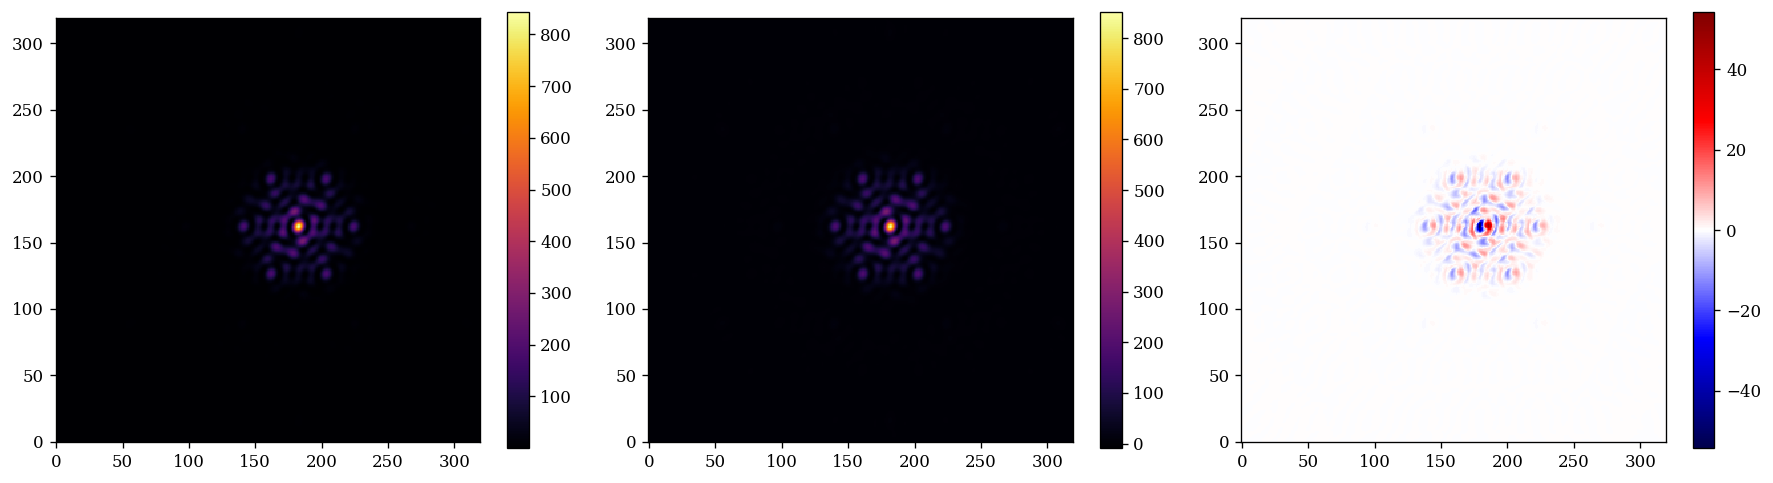

In [11]:
image = psf * flux
charge = ramp[-1]
res = image - charge
v = np.max(np.abs(res))

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(charge)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(res, seismic, vmin=-v, vmax=v)
plt.colorbar()

plt.tight_layout()
plt.show()

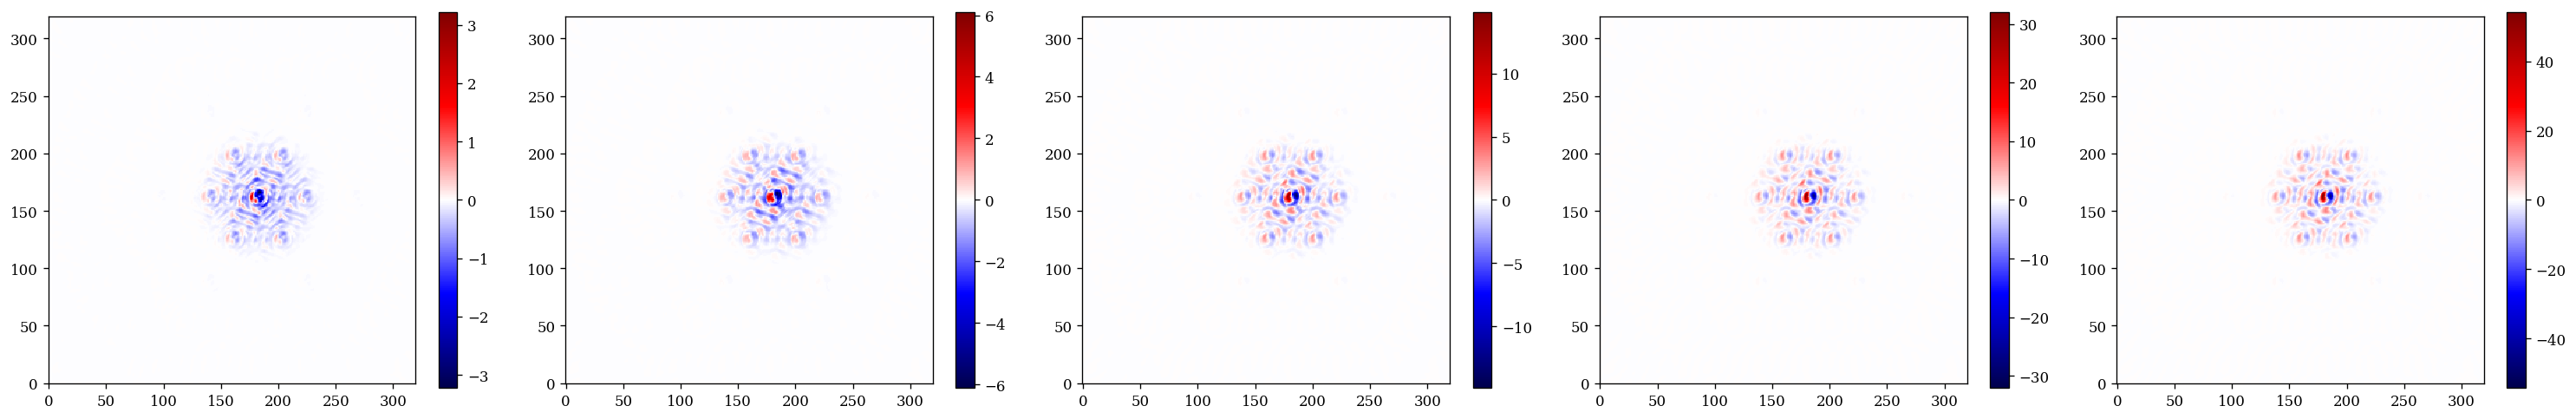

In [16]:
plt.figure(figsize=(25, 4))
# v = np.nanmax(np.abs(bleed))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    v = np.nanmax(np.abs(bleed[i]))
    plt.imshow(bleed[i], seismic, vmin=-v, vmax=v)
    plt.colorbar()

# plt.subplot(1, 3, 2)
# plt.imshow(charge)
# plt.colorbar()

# plt.subplot(1, 3, 3)
# plt.imshow(res, seismic, vmin=-v, vmax=v)
# plt.colorbar()

plt.tight_layout()
plt.show()